Populating the interactive namespace from numpy and matplotlib
Accuracy = 0.995734375
ROC curve on scores without softmax:


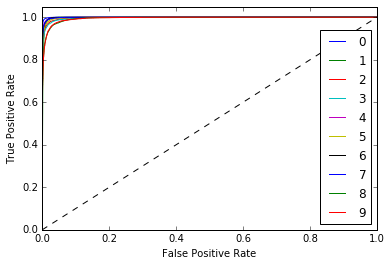

ROC curve on scores with softmax:


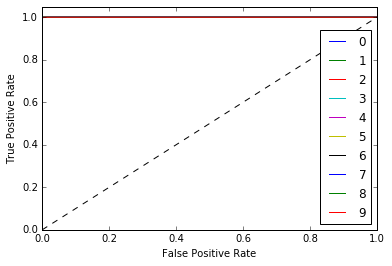

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      6302
        1.0       1.00      1.00      1.00      7186
        2.0       0.99      1.00      0.99      6355
        3.0       0.99      1.00      0.99      6523
        4.0       1.00      0.99      1.00      6272
        5.0       1.00      1.00      1.00      5771
        6.0       1.00      1.00      1.00      6323
        7.0       1.00      0.98      0.99      6698
        8.0       0.99      1.00      1.00      6224
        9.0       0.99      1.00      0.99      6346

avg / total       1.00      1.00      1.00     64000

Confusion matrix:
[[6298    0    2    0    0    0    0    0    2    0]
 [   0 7162    7    4    0    0    1    4    7    1]
 [   0    2 6351    2    0    0    0    0    0    0]
 [   0    0    7 6507    0    2    0    2    4    1]
 [   1    5    5    1 6231    0    3    3    5   18]
 [   0    0    0   15    0 5751    0    0    5    0]
 [   2    1    0    0    

In [2]:
%pylab inline
from metrics import *
main()